## **Import 400 news articles to do some exploratory clustering**

In [18]:
import pandas as pd

csv_url = 'https://raw.githubusercontent.com/jahnavi-maddhuri/bny-ai-risk-management/refs/heads/main/data/gnews.csv'
df = pd.read_csv(csv_url)

df.head()

,id,title,link,published,source,summary,query,fetched_at
0,14afc5960984be56afd562d076fab48345699e74290b5b...,Retail Sales Remain Resilient - BNY,https://news.google.com/rss/articles/CBMiwgFBV...,"Wed, 12 Nov 2025 11:16:25 GMT",BNY,"Australia's new ambassador to China, Scott Dew...","(""BNY Mellon"" OR ""Bank of New York Mellon"" OR ...",2025-11-12T11:29:07.233806-05:00
1,9de33d87790650e46d84dd144c58350ec47e9dd259bea4...,Black Kite Releases Global Adaptive AI Assessm...,https://news.google.com/rss/articles/CBMihwJBV...,"Wed, 12 Nov 2025 11:00:00 GMT",Morningstar,The Albanese government is considering buildin...,"(""BNY Mellon"" OR ""Bank of New York Mellon"" OR ...",2025-11-12T11:29:07.233806-05:00
2,6ae6e9a893b3dd72e214e2cfa3dfcbaabf6821621334e3...,ABC Arbitrage SA Takes Position in The Bank of...,https://news.google.com/rss/articles/CBMi1AFBV...,"Wed, 12 Nov 2025 11:46:28 GMT",MarketBeat,"Australia's new ambassador to China, Scott Dew...","(""BNY Mellon"" OR ""Bank of New York Mellon"" OR ...",2025-11-12T11:29:07.233806-05:00
3,eee8dff2da573b266d4f79039c7858d9139471f4914917...,Will The Bank of New York Mellon Corporation (...,https://news.google.com/rss/articles/CBMitgFBV...,"Wed, 12 Nov 2025 14:55:13 GMT",newser.com,The NSW Premier has announced that the state w...,"(""BNY Mellon"" OR ""Bank of New York Mellon"" OR ...",2025-11-12T11:29:07.233806-05:00
4,5713a6a6a3fe6c45f3e298e23026fa499dc41426df65b7...,BK Technologies Data Breach Exposes Sensitive ...,https://news.google.com/rss/articles/CBMiugFBV...,"Wed, 12 Nov 2025 11:31:28 GMT",The Critical Communications Review,Australian researchers have developed a ground...,"(""BNY Mellon"" OR ""Bank of New York Mellon"" OR ...",2025-11-12T11:29:07.233806-05:00


## **Preprocessing**

**Convert all summaries to lowercase and removing punctuation so the text is cleaner and easier to work with for clustering and further analysis.**

In [19]:
import re

# Convert to lowercase
df['summary'] = df['summary'].str.lower()

# Remove punctuation
df['summary'] = df['summary'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

print("Summary column after lowercasing and punctuation removal:")
print(df['summary'].head())

Summary column after lowercasing and punctuation removal:
0    australias new ambassador to china scott dewar...
1    the albanese government is considering buildin...
2    australias new ambassador to china scott dewar...
3    the nsw premier has announced that the state w...
4    australian researchers have developed a ground...
Name: summary, dtype: object


- **Loaded the English stopword list from NLTK.**

- **Removed common stopwords from each summary.**

- **Kept only meaningful words to improve the quality of clustering.**

In [20]:
import nltk
from nltk.corpus import stopwords

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word not in stop_words])

# Apply the function to the 'summary' column
df['summary'] = df['summary'].apply(remove_stopwords)

print("Summary column after stopword removal:")
print(df['summary'].head())

Summary column after stopword removal:
0    australias new ambassador china scott dewar ar...
1    albanese government considering building new n...
2    australias new ambassador china scott dewar ar...
3    nsw premier announced state host dozen major m...
4    australian researchers developed groundbreakin...
Name: summary, dtype: object


### **Converting text into TF-IDF features**

Used `TfidfVectorizer` to transform the cleaned summaries into numerical feature vectors.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'summary' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['summary'])

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (400, 3215)


### Finding the optimal number of clusters (Elbow Method)

* Ran K-Means with different values of *K* (from 1 to 10).
* Recorded the inertia for each *K* to measure how well the model fits the data.
* Plotted the inertia curve to visually identify the “elbow point,” which suggests the optimal number of clusters.

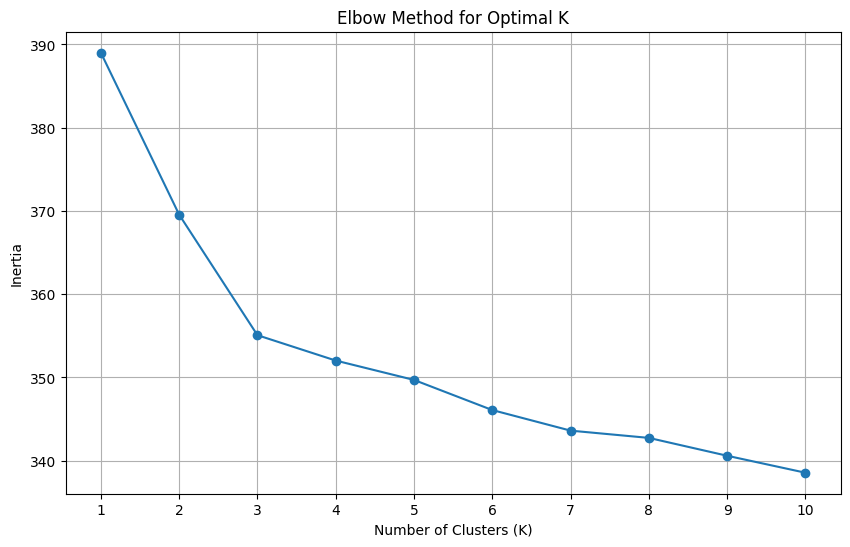

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Create an empty list to store the inertia values
inertia = []

# Iterate through a range of cluster numbers (e.g., from 1 to 10)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10) # n_init is set to 10 to suppress future warning
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [23]:
from sklearn.cluster import KMeans

# Initialize KMeans with the optimal number of clusters (k=4 based on the elbow method)
kmeans_model = KMeans(n_clusters=3, random_state=42, n_init='auto')

# Fit the KMeans model to the TF-IDF matrix
clusters = kmeans_model.fit_predict(tfidf_matrix)

# Add the cluster labels to the DataFrame
df['cluster'] = clusters

### **Extracting top terms for each cluster**

In [24]:
feature_names = tfidf_vectorizer.get_feature_names_out()

print("Top terms per cluster:")
for i, center in enumerate(kmeans_model.cluster_centers_):
    top_10_indices = center.argsort()[-10:][::-1]
    top_10_features = [feature_names[idx] for idx in top_10_indices]
    print(f"Cluster {i}: {', '.join(top_10_features)}")


Top terms per cluster:
Cluster 0: new, global, energy, significant, economic, public, challenges, potential, international, would
Cluster 1: fire, eightstory, building, institute, eight, fryazino, moscow, least, blaze, platan
Cluster 2: ai, leike, safety, openai, team, superalignment, jan, openais, coleader, dissolved


## ***The issue is that we need to figure out the criteria for categorization before clustering given what the current clusters look like***

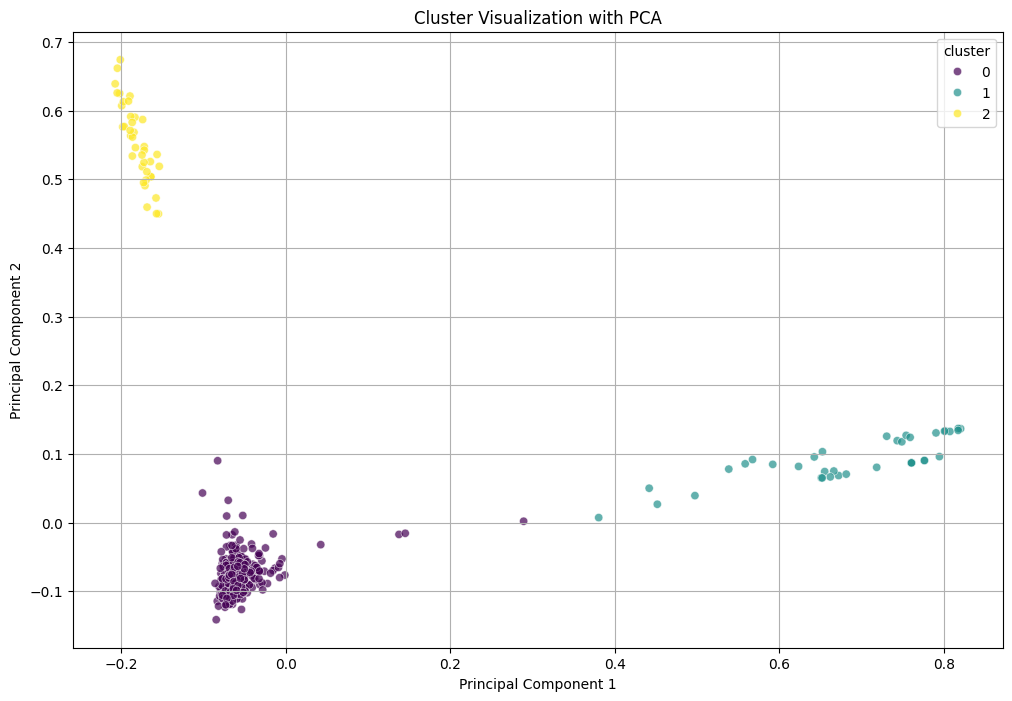

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensionality using PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(tfidf_matrix.toarray()) # Convert sparse matrix to dense array

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])
pca_df['cluster'] = df['cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='principal_component_1',
    y='principal_component_2',
    hue='cluster',
    palette='viridis',
    data=pca_df,
    legend='full',
    alpha=0.7
)
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [26]:
print("Number of articles per cluster:")
print(df['cluster'].value_counts().sort_index())

Number of articles per cluster:
cluster
0    324
1     37
2     39
Name: count, dtype: int64


### **Identifying representative articles for each cluster**

* Computed the centroid of each cluster from the TF-IDF feature space.
* Found the five summaries closest to each centroid to identify the most representative documents.
* Retrieved the original article links for these summaries to inspect their full content.


In [30]:
from sklearn.metrics import pairwise_distances

centroids = kmeans_model.cluster_centers_
tfidf_dense = tfidf_matrix.toarray()
closest_docs = {}

for cluster_id in range(kmeans_model.n_clusters):
    cluster_indices = np.where(df['cluster'] == cluster_id)[0]
    cluster_vectors = tfidf_dense[cluster_indices]
    centroid = centroids[cluster_id].reshape(1, -1)
    distances = pairwise_distances(cluster_vectors, centroid).reshape(-1)
    top5_idx = distances.argsort()[:5]
    top5_original_idx = cluster_indices[top5_idx]
    closest_docs[cluster_id] = top5_original_idx

    for idx in top5_original_idx:
        print(f"Cluster {cluster_id} - {df.loc[idx, 'link']}")

Cluster 0 - https://news.google.com/rss/articles/CBMiwwFBVV95cUxPeVpaRDduakJiMkxxa0FPbzA3RW5kQ21kVG1BS0M5YXo2OEQzdXVfTlZBcFJId1hkQTR6Q1kyVXR3cWNqUHBGRGlfXzc4eHBxYWRJMFotR05tTm5UQVhVaUJ0aW81QVRaWVZ6MzdfbEFtVjdHNkoyV0l4MXh4WXFHX1E2eXNvMF9CZldCVzNFUmFRakwzajlqSFE3X0NxUUVnUnMzY0NKZ0VYVG9rWG5sQ1BCWXdwZ192NDg5NUVGVDZ0WGM?oc=5
Cluster 0 - https://news.google.com/rss/articles/CBMingFBVV95cUxOZnZLVkViVmZQQ1VuQktOLTgydkZnMV9tVEF4THZhNUxyYUJFampTb3gyNlBjaklXWThKWnBWc2hraWRoMmwzbTJTTnVhWHAzYjZqcVNKQU5BeUl4bjQ0bVl2M0dnY0xEeFE2c1VnTzRVRGsxbFFWY1JEZUdQenZNZmJvcTE4NVNCQ3FQNWl2Qnc0d2ZKbm16djQyLXg0dw?oc=5
Cluster 0 - https://news.google.com/rss/articles/CBMilAFBVV95cUxPMmlRRXd2cmtNWFNfazZuWmh6aWFpUXdaWnBRWEdBTEpHdjhpNWd4dVFtMVlNV2xMZWVHV09GOHhqSXlaRjAxc3FCcFBvR3JTdE5mYjVZZnd1Zk9QbVJwaWg4czVKbGZWRVVIQkp5dUhRQmZLc3B3cC1tcW5oOGI3WG1KOTl6RExQSFlrX3d5NEhqTEVx?oc=5
Cluster 0 - https://news.google.com/rss/articles/CBMioAFBVV95cUxNZjJuaWw1LTloUVdHcm9NY3VUX3hwUGhkUlEyTVVVQjNJUjZaSVMwT212MFNhUUlvNG53TUYtM2NULUlZS

## **Try different K values**

In [13]:
# Initialize KMeans with the optimal number of clusters (k=4 based on the elbow method)
kmeans_model = KMeans(n_clusters=8, random_state=42, n_init='auto')

# Fit the KMeans model to the TF-IDF matrix
clusters = kmeans_model.fit_predict(tfidf_matrix)

# Add the cluster labels to the DataFrame
df['cluster'] = clusters

In [14]:
feature_names = tfidf_vectorizer.get_feature_names_out()

print("Top terms per cluster:")
for i, center in enumerate(kmeans_model.cluster_centers_):
    top_10_indices = center.argsort()[-10:][::-1]
    top_10_features = [feature_names[idx] for idx in top_10_indices]
    print(f"Cluster {i}: {', '.join(top_10_features)}")

Top terms per cluster:
Cluster 0: inflation, economic, global, interest, growth, central, supply, persistent, market, rates
Cluster 1: development, ai, vehicles, manufacturers, automotive, electric, industry, future, new, rapid
Cluster 2: public, local, uk, services, increased, government, facing, health, residents, financial
Cluster 3: fire, eightstory, building, institute, eight, fryazino, moscow, least, blaze, platan
Cluster 4: international, new, global, climate, significant, security, urgent, challenges, critical, efforts
Cluster 5: energy, summary, would, might, new, article, renewable, discuss, could, likely
Cluster 6: ai, leike, safety, openai, team, superalignment, jan, openais, coleader, dissolved
Cluster 7: new, innovative, experiences, digital, adapting, platforms, traditional, online, cultural, art


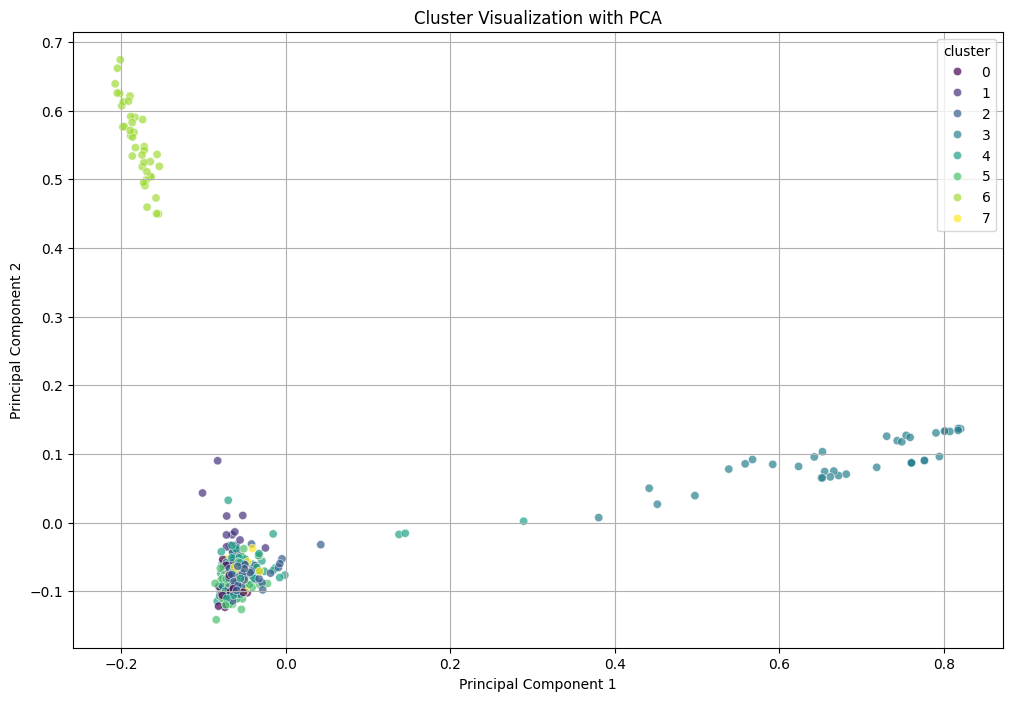

In [15]:
# Reduce dimensionality using PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(tfidf_matrix.toarray()) # Convert sparse matrix to dense array

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])
pca_df['cluster'] = df['cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='principal_component_1',
    y='principal_component_2',
    hue='cluster',
    palette='viridis',
    data=pca_df,
    legend='full',
    alpha=0.7
)
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [16]:
print("Number of articles per cluster:")
print(df['cluster'].value_counts().sort_index())

Number of articles per cluster:
cluster
0    44
1    17
2    69
3    37
4    98
5    60
6    39
7    36
Name: count, dtype: int64


## Key Findings + 
**Number of Clusters**
- ✅ well separated with 3 classes
- ❌ not as well separated with 10 classes <br> <br>

**Diverse Data Collection**
- Data overpopulated by Google News
- Data availability <br> <br>

**Optimize Google News Prompt** <br>
*Current Prompt* <br>
ENTITY_QUERIES <br>
>    BNY Mellon, Pershing, Dreyfus<br>
    NO sports, gossip <br>

THEME_QUERIES <br>
>    asset servicing, custody, securities services, <br>
    FX, repo market, liquidity management, lending, <br>
    Basel, capital requirements, operational resilience, <br>
    rating action, credit watch, outlook revised, <br>
    tokenized assets, market infrastructure <br>

*Must capture more diverse news*